In [1]:
import jax.numpy as jnp
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
from discrete_exterior_calculus import DEC
from icosphere import icosphere
import matplotlib.pyplot as plt

# nu:       1   2   3   4    5    6    7    8    9    10
# vertices: 12, 42, 92, 162, 252, 362, 492, 642, 812, 1002
nu = 3
vertices, faces = icosphere(nu=nu)
mesh_name = f"icosphere_v={len(vertices)}"
mesh = DEC.Mesh(vertices, faces)

print("highest vertex: ", jnp.max(vertices))

high_res_zmost_point = jnp.argmax(vertices[:, 2])
high_res_zleast_point = jnp.argmin(vertices[:, 2])
high_res_xmost_point = jnp.argmax(vertices[:, 0])
high_res_xleast_point = jnp.argmin(vertices[:, 0])
high_res_ymost_point = jnp.argmax(vertices[:, 1])
high_res_yleast_point = jnp.argmin(vertices[:, 1])

n = len(vertices)
q = 1


# Define the vector field
def vector_field(t, y, args):
    # Extract u and v from y
    u = y[:n]
    v = y[n:]
    # Compute derivatives
    du_dt = v
    dv_dt = jnp.tanh(mesh.laplace_matrix @ u)
    # Combine derivatives
    return jnp.concatenate([du_dt, dv_dt])


# Define the ODE term
term = ODETerm(vector_field)

# Solver settings
solver = Dopri5()  # Runge-Kutta method
saveat = SaveAt(ts=jnp.linspace(0, 10, 100))  # Save at 100 evenly spaced time points
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

# Initial conditions
u0 = jnp.zeros(n)  # Initial condition for u (e.g., zero displacement)
v0 = jnp.zeros(n)  # Initial condition for v (e.g., zero velocity)
u0 = u0.at[high_res_ymost_point].set(1.0)  # Example: Displace the middle point
y0 = jnp.concatenate([u0, v0])  # Combine u0 and v0 into a single state vector

# Solve the system
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=10,
    dt0=0.1,
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
)

# Extract solutions
diffrax_sol = sol.ys[:, :n]  # Displacement solutions over time

# Visualization (optional)
# import matplotlib.pyplot as plt


# # Save the solution to a file
# name = f"diffrax_wave_ico_{3}.json"
# mesh.dump_to_JSON(
#     name,
#     {
#         "wave": {
#             "data": diffrax_sol,
#             "start": 0,
#             "end": 10,
#         }
#     },
#     folder="../produced_solutions",
# )


/Users/theoruterwurtzen/Desktop/MSc Thesis/code/app/discrete_exterior_calculus/DEC.py:68: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  self.laplace_matrix = -spsla.spsolve(


highest vertex:  0.9794321


In [2]:
import numpy as np
from probabilistic_numerics import heat_kalman

# nu:       1   2   3   4    5    6    7    8    9    10
# vertices: 12, 42, 92, 162, 252, 362, 492, 642, 812, 1002
vertices, faces = icosphere(nu=3)

mesh_name = f"icosphere_v={len(vertices)}"
mesh = mesh = DEC.Mesh(vertices, faces)

zmost_point = jnp.argmax(vertices[:, 2])
zleast_point = jnp.argmin(vertices[:, 2])
xmost_point = jnp.argmax(vertices[:, 0])
xleast_point = jnp.argmin(vertices[:, 0])
ymost_point = jnp.argmax(vertices[:, 1])
yleast_point = jnp.argmin(vertices[:, 1])

n = len(mesh.vertices)


O = jnp.zeros((n, n))
I = jnp.eye(n)

curvature_matrix = jnp.block([-mesh.laplace_matrix, O, O])
value = jnp.block([I, O, O])
solution = jnp.block([I, O, O])
first_time_derivative = jnp.block([O, I, O])
second_time_derivative = jnp.block([O, O, I])


def non_linear_observation_function(state, time):
    return -jnp.tanh((curvature_matrix @ state)) - second_time_derivative @ state


derivatives = 2

initial_value = np.zeros(n * (derivatives + 1))
# above_mask = (mesh.vertices[:, 1] > 0).astype(float)
# distance_to_center = np.linalg.norm(mesh.vertices[:, [0, 2]] * [1.5, 3], axis=1)
# rbf = np.exp(-3 * (distance_to_center**2)) * 1
# initial_value[:n] = above_mask * rbf
initial_value[ymost_point] = 1.0
initial_value[2 * n : 3 * n] = jnp.tanh((-mesh.laplace_matrix @ initial_value[:n]))


timesteps = 50
delta_time = 10 / timesteps
heat_prior = False


# update_indicator = jnp.tile(jnp.array([True] + [True] * 9), timesteps // 10)
update_indicator = jnp.ones(timesteps, dtype=bool)
update_indicator = update_indicator.at[0].set(False)

kalman_sol, u_std = heat_kalman.solve_nonlinear_IVP(
    laplace_matrix=-mesh.laplace_matrix,
    initial_mean=initial_value,
    derivatives=derivatives,
    timesteps=timesteps,
    delta_time=delta_time,
    heat_prior=heat_prior,
    observation_function=non_linear_observation_function,
    update_indicator=update_indicator,
)

if False:
    pass
    # newname = f"nonlinear_{'heat_prior' if heat_prior else ''}_{mesh_name}.json"
    # print("Saving to", newname)
    # mesh.dump_to_JSON(
    #     newname,
    #     {
    #         "Initial Value": initial_value[:n],
    #         "Probabilistic Heat Equation": {
    #             "data": p_means[:, :n],
    #             "start": 0,
    #             "end": 1,
    #         },
    #         "Probabilistic Standard Dev.": {
    #             "data": (p_stds[:, :n]),
    #             "start": 0,
    #             "end": 1,
    #         },
    #         "eigenvectors": {
    #             "data": eigenvectors,
    #             "start": 0,
    #             "end": 1,
    #         },
    #         "areas": np.diagonal(mesh.star0.toarray()),
    #     },
    # )


domain = jnp.linspace(0, 10, timesteps)


/Users/theoruterwurtzen/Desktop/MSc Thesis/code/app/discrete_exterior_calculus/DEC.py:68: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  self.laplace_matrix = -spsla.spsolve(


Starting PIVP_heat_solve
92
Discretized IWP prior
Filtered on PDE observations
Smoothed PDE observations, done.


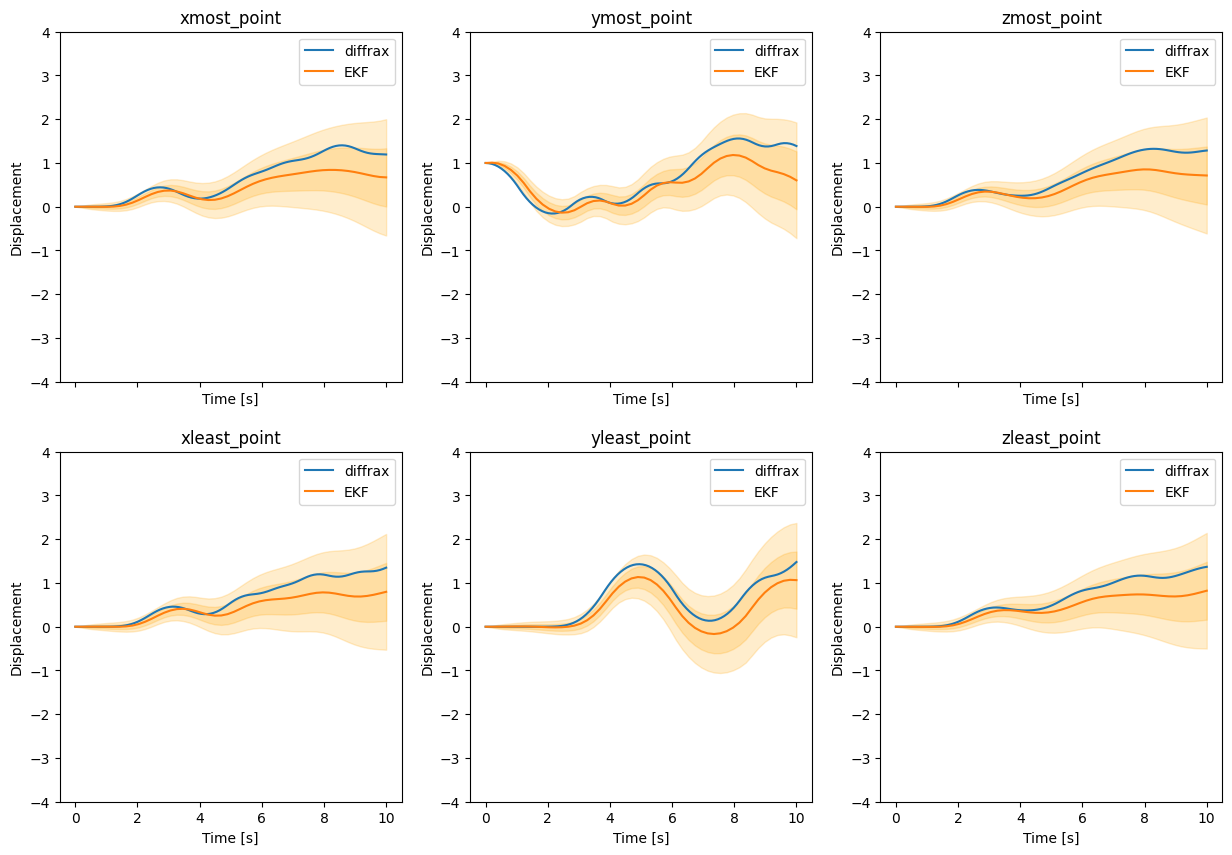

In [3]:
# plot the solution for the six chosen points
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

axs[0, 0].plot(sol.ts, diffrax_sol[:, high_res_xmost_point], label="diffrax")
axs[0, 1].plot(sol.ts, diffrax_sol[:, high_res_ymost_point], label="diffrax")
axs[0, 2].plot(sol.ts, diffrax_sol[:, high_res_zmost_point], label="diffrax")
axs[1, 0].plot(sol.ts, diffrax_sol[:, high_res_xleast_point], label="diffrax")
axs[1, 1].plot(sol.ts, diffrax_sol[:, high_res_yleast_point], label="diffrax")
axs[1, 2].plot(sol.ts, diffrax_sol[:, high_res_zleast_point], label="diffrax")

axs[0, 0].set_ylim((-4, 4))
axs[0, 1].set_ylim((-4, 4))
axs[0, 2].set_ylim((-4, 4))
axs[1, 0].set_ylim((-4, 4))
axs[1, 1].set_ylim((-4, 4))
axs[1, 2].set_ylim((-4, 4))

None


def plot_3std(ax, domain, means, stds, color):
    for i in range(1, 3):
        ax.fill_between(
            domain,
            means + i * stds,
            means - i * stds,
            alpha=0.2,
            color=color,
        )


axs[0, 0].plot(domain, kalman_sol[:, xmost_point], label="EKF")
plot_3std(
    axs[0, 0], domain, kalman_sol[:, xmost_point], u_std[:, xmost_point], color="orange"
)

axs[0, 1].plot(domain, kalman_sol[:, ymost_point], label="EKF")
plot_3std(
    axs[0, 1], domain, kalman_sol[:, ymost_point], u_std[:, ymost_point], color="orange"
)

axs[0, 2].plot(domain, kalman_sol[:, zmost_point], label="EKF")
plot_3std(
    axs[0, 2], domain, kalman_sol[:, zmost_point], u_std[:, zmost_point], color="orange"
)

axs[1, 0].plot(domain, kalman_sol[:, xleast_point], label="EKF")
plot_3std(
    axs[1, 0],
    domain,
    kalman_sol[:, xleast_point],
    u_std[:, xleast_point],
    color="orange",
)

axs[1, 1].plot(domain, kalman_sol[:, yleast_point], label="EKF")
plot_3std(
    axs[1, 1],
    domain,
    kalman_sol[:, yleast_point],
    u_std[:, yleast_point],
    color="orange",
)

axs[1, 2].plot(domain, kalman_sol[:, zleast_point], label="EKF")
plot_3std(
    axs[1, 2],
    domain,
    kalman_sol[:, zleast_point],
    u_std[:, zleast_point],
    color="orange",
)

axs[0, 0].set_title("xmost_point")
axs[0, 1].set_title("ymost_point")
axs[0, 2].set_title("zmost_point")
axs[1, 0].set_title("xleast_point")
axs[1, 1].set_title("yleast_point")
axs[1, 2].set_title("zleast_point")

for row in axs:
    for ax in row:
        ax.set_ylabel("Displacement")
        ax.set_xlabel("Time [s]")
        ax.legend()
